# Bias-variance tradeoff

(for real this time)

## The "true" function

Our "true" function **f(x)** is:

### $$f(x) = 50 / (x^{0.6} + 0.001)) + sin(x^{0.75})$$

Let's say we have 500 total x, y pairs in the entire population:

In [1]:
import numpy as np

def f(x):
    return (50 / (x**0.6 + 0.001)) * np.sin(x**0.75)

### Irreducible noise

Because of our measurement error, we have a source of what is called "irreducible noise". This is noise we cannot account for due to our model.

We define this noise as **N(0, 4)**, which specifies random normal noise with mean 0 and standard deviation 4.


In [2]:
pop_noise_std = 20

def irreducible_noise(x):
    return np.random.normal(0, pop_noise_std, size=len(x))


pop_size = 500
pop_vals_max = 65
pop_vals_min = -35
pop_ind_reps = 20

# Generate the measured y points from our function f_noisy():
def f_noisy(x):
    pop_vals = f(x) + irreducible_noise(x)
    pop_vals = np.minimum(np.repeat(pop_vals_max, pop_size), pop_vals)
    pop_vals = np.maximum(np.repeat(pop_vals_min, pop_size), pop_vals)
    return pop_vals

### Measuring our predicted velocity at times "x"

Our unknown "population" of possible measured points has 20 possible measured velocities at different times "x".

These are the possible measurements with error at each time. In reality, we would have infinite possibilities.

In [3]:
# Generate our measured y variables from a series of x times:
x = np.linspace(0.01, 30.01, pop_size)

y = np.array([f_noisy(x) for i in range(pop_ind_reps)]).T

print x.shape
print y.shape

(500,)
(500, 20)


### Plot of the true function and points

First load our plotting packages.

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

Below we plot out the time, measurement (x, y) pairs in our population along with the line that shows our true function F() that the measurements would be with no measurement error.

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in power


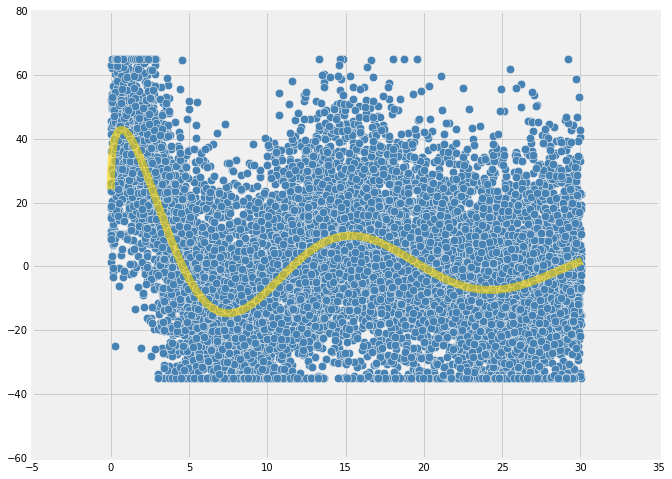

In [5]:
plt.figure(figsize=(10,8))

true_func_lw = 8
true_func_alpha = 0.6

# draw our function without noise:
line_x = np.linspace(-0.1, 30.1, 2500)
line_y = f(line_x)
plt.plot(line_x, line_y, lw=true_func_lw, c='gold', alpha=true_func_alpha)

# draw the x, y pairs as a scatter plot:
for i in range(pop_ind_reps):
    plt.scatter(x, y[:, i], s=70, c='steelblue')

plt.show()

## Samples from the population of measurements

We measure the velocity at x sample time points. This is a sample from the full distribution of measurements. 

We have limited observational ability. Perhaps each time we sample, we have 40 points of the possible 500 times.

Here we are just measuring the velocity ourself:

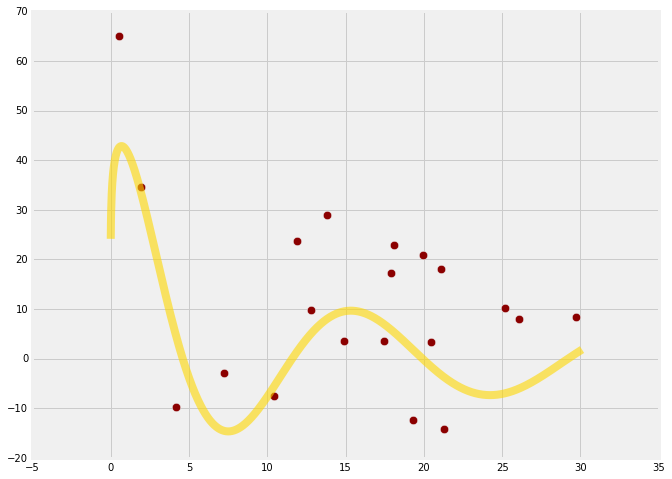

In [6]:
plt.figure(figsize=(10,8))

#sample_size_low = 25
#sample_size_high = 50
sample_size = 20
sample_alpha = 1.0
sample_dot_size = 70

# draw our function without noise:
plt.plot(line_x, line_y, lw=true_func_lw, c='gold', alpha=true_func_alpha)

y_samp_col = np.random.choice(range(pop_ind_reps), size=1)

# draw the sampled x, y pairs as a scatter plot:
sample_indices = np.random.choice(range(0, pop_size),
                                  size=sample_size,
                                  #size=np.random.randint(sample_size_low, high=sample_size_high, size=1), 
                                  replace=False)

plt.scatter(x[sample_indices], y[sample_indices, y_samp_col], s=sample_dot_size, c='darkred', alpha=sample_alpha)

plt.show()

## Functions to define polynomial models

Here are the (complicated!!) functions for generating arbitrary polynomial models of our velocity from times.

Don't worry about this now... I can talk to you later about how they work.

In [7]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns

# Function to get a sample
def sample_inds(x, y, inds=None):
    if inds == None:
        si = np.random.choice(range(0, pop_size), size=sample_size, replace=False)
    else:
        si = inds
    xs = x[si]
    ys = y[si]
    return xs, ys


# model generation function
def poly_model(y, x, line_x, n=5, p=1):
    varnames = ['x'+str(xname+1) for xname in range(p)]
    
    data = {varname:x**(power+1) for power, varname in zip(range(p), varnames)}
    data.update({'y':y})
    data = pd.DataFrame(data)
    
    xmat = data[varnames].values
    ymat = data['y'].values
    
    lm = LinearRegression()
    lm.fit(xmat, ymat)
    
    line_x_data = {varname:line_x**(power+1) for power, varname in zip(range(p), varnames)}
    line_x_data = pd.DataFrame(line_x_data)
    
    return lm.predict(line_x_data.values)



mult_samp_point_size = 40
mult_samp_lw = 4
mult_samp_alpha = 0.9

def plot_multi(x, y, line_x, n=5, p=1):
    colors = sns.color_palette("Set2", n)
    
    y_hats = []
    
    x_inds = np.random.choice(range(0, pop_size), size=sample_size, replace=False)
    y_inds = np.random.choice(range(pop_ind_reps), size=n, replace=False)
    
    y_true = f(x[x_inds])
    
    y_h2 = []
    y_t2 = []    
    
    for i in range(n):
        y_h2.append([])
        
        xs, ys = sample_inds(x, y[:, y_inds[i]], inds=x_inds)
        
        y_pred = poly_model(ys, xs, line_x, n=n, p=p)
        y_t2.append(ys)
        
        y_hats.append(poly_model(ys, xs, xs, n=n, p=p))
        y_h2[-1].append(poly_model(ys, xs, xs, n=n, p=p))
        y_h2[-1].append(poly_model(ys, xs, xs, n=n, p=p))        
        
        # draw the sampled x, y pairs as a scatter plot:
        plt.scatter(xs, ys, s=mult_samp_point_size, c=colors[i])        
        
        # draw the model line:
        plt.plot(line_x, y_pred, lw=mult_samp_lw, c=colors[i], alpha=mult_samp_alpha)
    
    return y_hats, y_true, y_h2, y_t2


## Constructing a model from our sample.

I decide to measure the velocity with a linear regression using just the time. 

The model is defined as:

### $$\hat{y} = \beta_0 + \beta_1x$$

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/pizzato/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


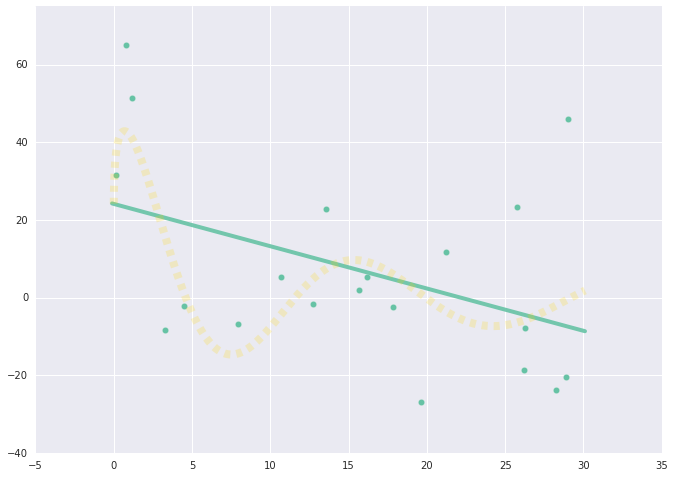

In [8]:
true_func_bg_ls = 'dashed'
true_func_bg_alpha = 0.2

plt.figure(figsize=(10,8))

y_hats, y_trues, _, _ = plot_multi(x, y, line_x, n=1, p=1)

plt.plot(line_x, line_y, lw=true_func_lw, c='gold', 
         alpha=true_func_bg_alpha, ls=true_func_bg_ls)

x_axis_limits = [-5, 35]
y_axis_limits = [-40, 75]

axes = plt.gca()
axes.set_xlim(x_axis_limits)
axes.set_ylim(y_axis_limits)

plt.show()

### Model 1 fit to samples

I decide to recruit 4 friends to help me model the velocities in hopes that I can reduce the error of the measurements.

We can now measure the **bias** and the **variance** across across the samples. 

### Squared bias

The **bias^2** is one source of error in our model. It is the error for **how much average predictions of velocity across the sample observations at each time deviate from the true function**.

### $$bias^2 = \big(E[f_{sample}(x_{ti})] - f(x_{ti})\big)^2$$

We calculate the bias across samples **at each measurement time point**. Then we can average the biases of the measurements for how biased our chosen model is in general.

The squared bias is a number that essentially describes **our model's assumption of how simple the true function is**. A higher squared bias means we are assuming that **variance in prediction errors is due more to noise than real variance.**

In [9]:
def bias_sq(y_hats, y_true):
    y_hats_element_means = np.mean(np.array(y_hats), axis=0)
    element_wise_biases_sq = (y_hats_element_means - y_true)**2
    mean_bias_sq = np.mean(element_wise_biases_sq)
    return mean_bias_sq

### Variance of predictions

There is another source of error in the model: the **variance of our predictions**. This is error describing **how much our predictions across the sample observations at each time deviate from the mean prediction at that time point**.

### $$variance = E\bigg[\big(Fsample(x_{ti}\big) - E\big[Fsample(x_{ti})\big])^2\bigg]$$

We also calculate the variance across samples **at each measurement time point**. We can then average the variances of the measurements.

The variance is a number that describes **our model's assumption that our prediction error is small and that a more complex model will generalize better to future measurements than a simpler model**.

In [10]:
def variance(y_hats):
    y_hats_element_means = np.mean(np.array(y_hats), axis=0)
    y_hats_element_variances = [(yh - y_hats_element_means)**2 for yh in y_hats]
    mean_element_variances = np.mean(np.array(y_hats_element_variances), axis=0)
    mean_variance = np.mean(mean_element_variances)
    return mean_variance

### Total error of model

In total we have three sources of error in our model that comprise the errors of our predictions:

### $$error = bias^2 + variance + irreducible error$$

## Simple model across many samples

We keep our simple model, but recruit 4 friends to help measure. Each friend has some error in their measurements, but the errors are not the same. The more friends the better!

### $$\hat{y} = \beta_0 + \beta_1x + \beta_2x^2$$
### $$\hat{y} = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3 + \beta_4x^4$$
### $$\hat{y} = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3 + \beta_4x^4 + \beta_5x^5$$

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Bias: 9.73445851844
Variance: 11.7385713641
-Bias: 22.3687208078
-Variance: 0.0
-Bias: 21.3606047577
-Variance: 0.0
-Bias: 17.3436054631
-Variance: 0.0
-Bias: 22.4133666281
-Variance: 0.0


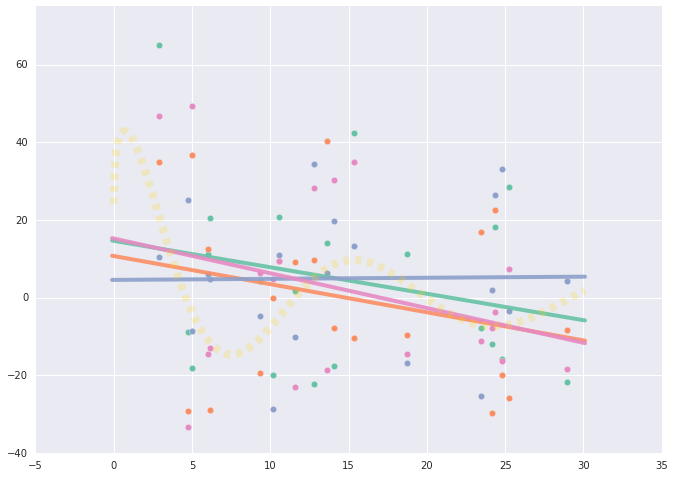

In [11]:
plt.figure(figsize=(10,8))

y_hats, y_true, yh2, yt2 = plot_multi(x, y, line_x, n=4, p=1)

print "Bias:", np.sqrt(bias_sq(y_hats, y_true))
print "Variance:", variance(y_hats)

for yh,yt in zip(yh2, yt2):
    print "-Bias:", np.sqrt(bias_sq(yh, yt))
    print "-Variance:", variance(yh)
    

plt.plot(line_x, line_y, lw=true_func_lw, c='gold', 
         alpha=true_func_bg_alpha, ls=true_func_bg_ls)

axes = plt.gca()
axes.set_xlim(x_axis_limits)
axes.set_ylim(y_axis_limits)

plt.show()

## More complex model

Since our first model looks pretty shitty, we decide to remeasure and fit a model with more polynomial transformations of our time variable x:

### $$\hat{y} = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3$$

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Bias: 7.37142044411
Variance: 22.8374260041
-Bias: 19.2385629086
-Variance: 0.0
-Bias: 21.2640127785
-Variance: 0.0
-Bias: 21.4398197609
-Variance: 0.0
-Bias: 19.5068958145
-Variance: 0.0


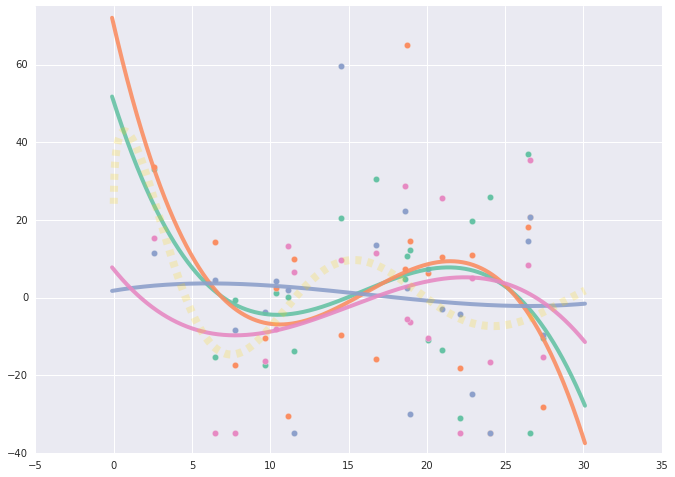

In [12]:
plt.figure(figsize=(10,8))

y_hats, y_true, yh2, yt2 = plot_multi(x, y, line_x, n=4, p=3)

print "Bias:", np.sqrt(bias_sq(y_hats, y_true))
print "Variance:", variance(y_hats)

for yh,yt in zip(yh2, yt2):
    print "-Bias:", np.sqrt(bias_sq(yh, yt))
    print "-Variance:", variance(yh)

plt.plot(line_x, line_y, lw=true_func_lw, c='gold', 
         alpha=true_func_bg_alpha, ls=true_func_bg_ls)

axes = plt.gca()
axes.set_xlim(x_axis_limits)
axes.set_ylim(y_axis_limits)

plt.show()

## Much more complex models

We get pretty excited from the last one, and decide to fit a couple of models with way more polynomial expansions of the time variable:

### $$\hat{y} = \beta_0 + \beta_1x + ... + \beta_7x^7$$
### $$\hat{y} = \beta_0 + \beta_1x + ... + \beta_8x^8$$

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Bias: 6.56559873267
Variance: 142.271248288
-Bias: 15.1909256041
-Variance: 0.0
-Bias: 12.6339372372
-Variance: 0.0
-Bias: 11.1140279738
-Variance: 0.0
-Bias: 13.7595091313
-Variance: 0.0


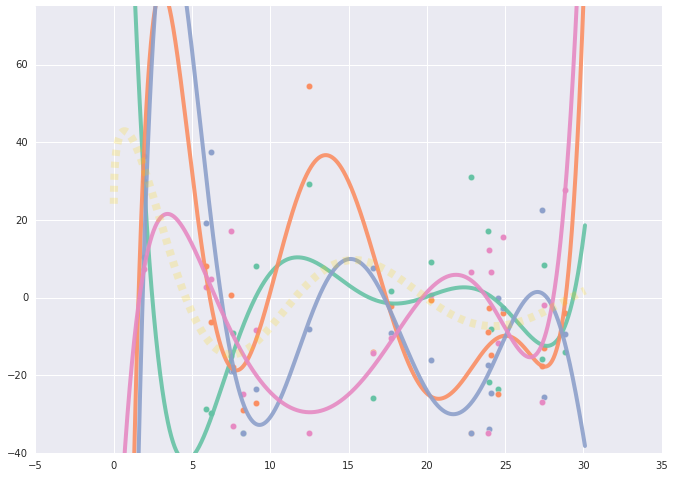

In [13]:
plt.figure(figsize=(10,8))

y_hats, y_true, yh2, yt2 = plot_multi(x, y, line_x, n=4, p=7)

print "Bias:", np.sqrt(bias_sq(y_hats, y_true))
print "Variance:", variance(y_hats)

for yh,yt in zip(yh2, yt2):
    print "-Bias:", np.sqrt(bias_sq(yh, yt))
    print "-Variance:", variance(yh)

plt.plot(line_x, line_y, lw=true_func_lw, c='gold', 
         alpha=true_func_bg_alpha, ls=true_func_bg_ls)

axes = plt.gca()
axes.set_xlim(x_axis_limits)
axes.set_ylim(y_axis_limits)

plt.show()

/Users/pizzato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Bias: 5.32848450998
Variance: 182.902697836
-Bias: 20.174912512
-Variance: 0.0
-Bias: 7.91470834643
-Variance: 1.32348898008e-23
-Bias: 14.2559307639
-Variance: 0.0
-Bias: 14.576936065
-Variance: 0.0
-Bias: 14.480982077
-Variance: 5.29395592034e-23
-Bias: 12.7485064824
-Variance: 0.0
-Bias: 9.82897718215
-Variance: 2.11758236814e-22
-Bias: 13.000381555
-Variance: 2.11758236814e-22
-Bias: 8.354053117
-Variance: 0.0
-Bias: 10.6739281907
-Variance: 5.29395592034e-23


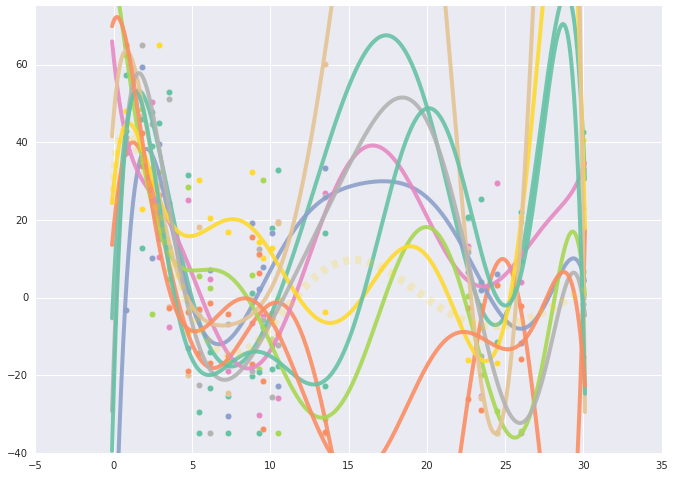

In [14]:
plt.figure(figsize=(10,8))

y_hats, y_true, yh2, yt2 = plot_multi(x, y, line_x, n=10, p=8)

print "Bias:", np.sqrt(bias_sq(y_hats, y_true))
print "Variance:", variance(y_hats)

for yh,yt in zip(yh2, yt2):
    print "-Bias:", np.sqrt(bias_sq(yh, yt))
    print "-Variance:", variance(yh)

plt.plot(line_x, line_y, lw=true_func_lw, c='gold', 
         alpha=true_func_bg_alpha, ls=true_func_bg_ls)

axes = plt.gca()
axes.set_xlim(x_axis_limits)
axes.set_ylim(y_axis_limits)

plt.show()